In [1]:
cd /workspace/fast-influence-functions/

/workspace/fast-influence-functions


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from experiments.visualization import *

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
import torch
from experiments import hans

In [4]:
ls /export/home/hguo/Experiments/20201209/hans/

hans-augmentation-new-only-z.hans.constituent.3.False.pth
hans-augmentation-new-only-z.hans.lexical_overlap.3.False.pth
hans-augmentation-new-only-z.hans.subsequence.3.False.pth
hans-augmentation-new-only-ztest.hans.constituent.3.False.pth
hans-augmentation-new-only-ztest.hans.lexical_overlap.3.False.pth
hans-augmentation-new-only-ztest.hans.subsequence.3.False.pth
hans-augmentation-new-z-and-ztest.hans.constituent.3.False.pth
hans-augmentation-new-z-and-ztest.hans.lexical_overlap.3.False.pth
hans-augmentation-new-z-and-ztest.hans.subsequence.3.False.pth


In [8]:
TASK_NAME = "mnli-2"

if TASK_NAME == "mnli-2":
    BASE_PATH = "/export/home/hguo/Experiments/20201209/mnli/"
if TASK_NAME == "hans":
    BASE_PATH = "/export/home/hguo/Experiments/20201209/hans/"

output_collections = {}
for train_heuristic in hans.DEFAULT_EVAL_HEURISTICS:
    _output_collections = {}
    for version in ["new-only-z", "new-only-ztest", "new-z-and-ztest"]:
        _output_collections[version] = torch.load(os.path.join(
            BASE_PATH,
            f"hans-augmentation-{version}."
            f"{TASK_NAME}.{train_heuristic}.3.False.pth")
        )

    output_collections[train_heuristic] = _output_collections

In [9]:
original_performance_collections = torch.load(
    "/export/home/hguo/Experiments/20201209/original-performances.pt")
def _get_original_performance(metric_name: str, slice_name: str) -> float:
    if metric_name == "loss":
        _metric_name = "losses"
    if metric_name == "accuracy":
        _metric_name = "accuracies"

    # All models are trained on `mnli-2`.
    return original_performance_collections[_metric_name]["mnli-2"][slice_name]

In [11]:
# MNLI-2: 6.13, HANS: 5.79
# diffs = []
# for heuristic_eval in hans.DEFAULT_EVAL_HEURISTICS:
#     _diffs = []
#     base = _get_original_performance("accuracy", heuristic_eval)
#     for heuristic_train in hans.DEFAULT_EVAL_HEURISTICS:
#         for ri in range(3):
#             v = (
#                 output_collections
#                 [heuristic_train]
#                 ["new-only-z"]
#                 [f"most-helpful-{ri}-10-0.0001-"]
#                 [-1]
#                 ["accuracy"]
#                 [heuristic_eval]
#             )
            
#             _diffs.append(v - base)

#     diffs.extend(_diffs)
#     print(np.mean(_diffs))
# print(f"Avg Improvement {np.mean(diffs) * 100:.2f} ({len(diffs)})")

In [7]:
if len(hans.VERSION_2_NUM_DATAPOINTS_CHOICES) != 1:
    raise ValueError
if len(hans.VERSION_2_LEARNING_RATE_CHOICES) != 1:
    raise ValueError
COMMON_KEY_SUFFIX = f"{hans.VERSION_2_NUM_DATAPOINTS_CHOICES[0]}-{hans.VERSION_2_LEARNING_RATE_CHOICES[0]}-"
display(hans.VERSION_2_NUM_DATAPOINTS_CHOICES)
display(hans.VERSION_2_LEARNING_RATE_CHOICES)
display(COMMON_KEY_SUFFIX)

[10]

[0.0001]

'10-0.0001-'

In [8]:
display(output_collections.keys())
for k_1 in output_collections.keys():
    for k_2 in output_collections[k_1].keys():
        for key in output_collections[k_1][k_2].keys():
            if not key.endswith(COMMON_KEY_SUFFIX):
                raise ValueError

dict_keys(['lexical_overlap', 'subsequence', 'constituent'])

In [9]:
# A couple of things to test
# 1. For z and for a given heuristic, random performances should be the same
# 2. For a given heuristic, helpful/harmful performances should be different
# 3. z/z-test should have the same batch-size, whereas z+z-test should have double batch size
# 4. For z-test and for a given heuristics (and replcation-index?), random and non-random should be similar
# 5. For a given heuristic and replcation-index, random performances should not be similar between z/z-test/z+z-test

# 1.
for version in ["new-only-z", "new-only-ztest", "new-z-and-ztest"]:
    for heuristic in hans.DEFAULT_EVAL_HEURISTICS:
        print(f"{heuristic:<20} {version:<20}", end="")
        values = output_collections[heuristic][version][f"random-2-{COMMON_KEY_SUFFIX}"][7]["loss"]
        for heuristic_2 in hans.DEFAULT_EVAL_HEURISTICS:
            print(f"{values[heuristic_2]:.3f}", end=" ")

        print()
    print()

# 2.
print("\n\n\n")
for version in ["new-only-z", "new-only-ztest", "new-z-and-ztest"]:
    for heuristic in hans.DEFAULT_EVAL_HEURISTICS:
        print(f"{heuristic:<20} {version:<20}", end="")
        values = output_collections[heuristic][version][f"most-helpful-0-{COMMON_KEY_SUFFIX}"][3]["loss"]
        for heuristic_2 in hans.DEFAULT_EVAL_HEURISTICS:
            print(f"{values[heuristic_2]:.3f}", end=" ")

        print()
    print()

print("\n\n\n")
for version in ["new-only-z", "new-only-ztest", "new-z-and-ztest"]:
    for heuristic in hans.DEFAULT_EVAL_HEURISTICS:
        print(f"{heuristic:<20} {version:<20}", end="")
        values = output_collections[heuristic][version][f"most-harmful-0-{COMMON_KEY_SUFFIX}"][3]["loss"]
        for heuristic_2 in hans.DEFAULT_EVAL_HEURISTICS:
            print(f"{values[heuristic_2]:.3f}", end=" ")

        print()
    print()

lexical_overlap      new-only-z          1.324 1.127 0.902 
subsequence          new-only-z          1.324 1.127 0.902 
constituent          new-only-z          1.324 1.127 0.902 

lexical_overlap      new-only-ztest      1.328 1.144 0.918 
subsequence          new-only-ztest      1.315 1.125 0.901 
constituent          new-only-ztest      1.225 1.056 0.840 

lexical_overlap      new-z-and-ztest     1.326 1.135 0.910 
subsequence          new-z-and-ztest     1.319 1.126 0.902 
constituent          new-z-and-ztest     1.274 1.091 0.871 





lexical_overlap      new-only-z          1.004 0.865 0.715 
subsequence          new-only-z          1.023 0.863 0.711 
constituent          new-only-z          1.131 0.934 0.720 

lexical_overlap      new-only-ztest      1.312 1.140 0.917 
subsequence          new-only-ztest      1.315 1.117 0.896 
constituent          new-only-ztest      1.368 1.166 0.906 

lexical_overlap      new-z-and-ztest     1.126 0.975 0.789 
subsequence          new-z-and-

In [10]:
# 4.
for version in ["new-only-ztest"]:
    for heuristic in hans.DEFAULT_EVAL_HEURISTICS:
        print(f"{heuristic:<20} {version:<20}")
        for experiment_type in hans.EXPERIMENT_TYPES:
            print(f"\t\t{experiment_type}")
            for replica_index in range(hans.DEFAULT_NUM_REPLICAS):
                values = output_collections[heuristic][version][f"{experiment_type}-{replica_index}-{COMMON_KEY_SUFFIX}"][2]["loss"]
                for heuristic_2 in hans.DEFAULT_EVAL_HEURISTICS:
                    print(f"{values[heuristic_2]:.3f}", end=" ")

                print()
            print()
        print()
    print()

lexical_overlap      new-only-ztest      
		most-helpful
1.390 1.208 0.972 
1.479 1.288 1.039 
1.403 1.213 0.973 

		most-harmful
1.515 1.314 1.057 
1.239 1.066 0.858 
1.408 1.218 0.979 

		random
1.395 1.202 0.967 
1.486 1.290 1.040 
1.512 1.311 1.055 


subsequence          new-only-ztest      
		most-helpful
1.391 1.189 0.953 
1.453 1.247 1.003 
1.420 1.223 0.981 

		most-harmful
1.531 1.321 1.062 
1.285 1.083 0.870 
1.395 1.193 0.958 

		random
1.419 1.217 0.979 
1.456 1.248 0.999 
1.509 1.306 1.050 


constituent          new-only-ztest      
		most-helpful
1.426 1.221 0.956 
1.598 1.384 1.109 
1.424 1.217 0.959 

		most-harmful
1.526 1.321 1.056 
1.361 1.157 0.904 
1.448 1.241 0.982 

		random
1.441 1.232 0.966 
1.526 1.318 1.048 
1.469 1.273 1.018 





In [11]:
# 5.
for heuristic in hans.DEFAULT_EVAL_HEURISTICS:
    for experiment_type in ["random"]:
        for replica_index in range(hans.DEFAULT_NUM_REPLICAS):
            print(f"{heuristic:<20} {replica_index:<20}")
            for version in ["new-only-z", "new-only-ztest", "new-z-and-ztest"]:
                print(f"{version:<20}", end="\t")
                values = output_collections[heuristic][version][f"{experiment_type}-{replica_index}-{COMMON_KEY_SUFFIX}"][7]["loss"]
                for heuristic_2 in hans.DEFAULT_EVAL_HEURISTICS:
                    print(f"{values[heuristic_2]:.3f}", end=" ")

                print()
            print()
        print()
    print()

lexical_overlap      0                   
new-only-z          	1.153 0.976 0.785 
new-only-ztest      	1.080 0.918 0.758 
new-z-and-ztest     	1.112 0.943 0.769 

lexical_overlap      1                   
new-only-z          	1.238 1.051 0.836 
new-only-ztest      	1.249 1.081 0.872 
new-z-and-ztest     	1.241 1.064 0.852 

lexical_overlap      2                   
new-only-z          	1.324 1.127 0.902 
new-only-ztest      	1.328 1.144 0.918 
new-z-and-ztest     	1.326 1.135 0.910 



subsequence          0                   
new-only-z          	1.153 0.976 0.785 
new-only-ztest      	1.101 0.921 0.762 
new-z-and-ztest     	1.126 0.948 0.773 

subsequence          1                   
new-only-z          	1.238 1.051 0.836 
new-only-ztest      	1.217 1.016 0.816 
new-z-and-ztest     	1.225 1.032 0.825 

subsequence          2                   
new-only-z          	1.324 1.127 0.902 
new-only-ztest      	1.315 1.125 0.901 
new-z-and-ztest     	1.319 1.126 0.902 



constituent       

In [12]:
import numpy as np
import matplotlib.pyplot as plt


def plot_Xs_and_Ys_dict(
        axis: Subplot,
        Xs: List[float],
        Ys_dict: Dict[str, List[List[float]]],
        baseline: float,
        title: str,
        xlabel: str,
        ylabel: str,
        xscale_log: bool = True,
        yscale_log: bool = True,
        output_file_name: Optional[str] = None,
) -> None:

    color_map = {
        "helpful-lexical_overlap": "#015758",
        "helpful-subsequence": "#1B8C81",
        "helpful-constituent": "#A6BF80",
        "harmful-lexical_overlap": "#EC2F3B",
        "harmful-subsequence": "#F26249",
        "harmful-constituent": "#FF9B5A",
        "random": "lightgrey",
        "z-test-lexical_overlap": "darkgrey",
        "z-test-subsequence": "darkgrey",
        "z-test-constituent": "darkgrey",
    }

    for tag in Ys_dict.keys():
        if tag not in color_map.keys():
            raise ValueError

        color = color_map[tag]
        data = np.array(Ys_dict[tag])
        is_random_data_point = "random" in tag
        # `data` should be [n, m]
        # where `n` is the number of independent trials
        # and `m` is the number of experiments within each trial
        if len(data.shape) != 2:
            raise ValueError(f"`data` should be an 2d array, {data.shape}")

        if data.shape[0] != 1:
            # i.e., it has multiple trials
            data_mean = [baseline] + data.mean(axis=0).tolist()
            data_max = [baseline] + data.max(axis=0).tolist()
            data_min = [baseline] + data.min(axis=0).tolist()
            # data_std = [0.0] + data.std(axis=0).tolist()
            axis.plot(
                Xs,
                data_mean,
                color=color,
                label=tag,
                linestyle=("--" if is_random_data_point else None))

            axis.fill_between(
                Xs,
                data_max,
                data_min,
                alpha=0.25,
                color=color)
        else:
            raise ValueError

    if xscale_log is True:
        axis.set_xscale("log")

    if yscale_log is True:
        axis.set_yscale("log")

    axis.set_xlabel(xlabel, fontsize=30)
    axis.set_ylabel(ylabel, fontsize=30)
    axis.set_title(title, fontsize=30)
    # axis.legend(fontsize=15)

    if output_file_name is not None:
        plt.savefig(output_file_name)

In [13]:
# For every subfig, we need the following lines
# 1. Random [which would be the same for each heuristic]
# 2. z-test [which would be the similar for each heuristic]
# 3. Helpful from each heuristic
# 4. Harmful from each heuristic
# 5. (Optional) Helpful + z-test from each heuristic
# 6. (Optional) Harmful + z-test from each heuristic

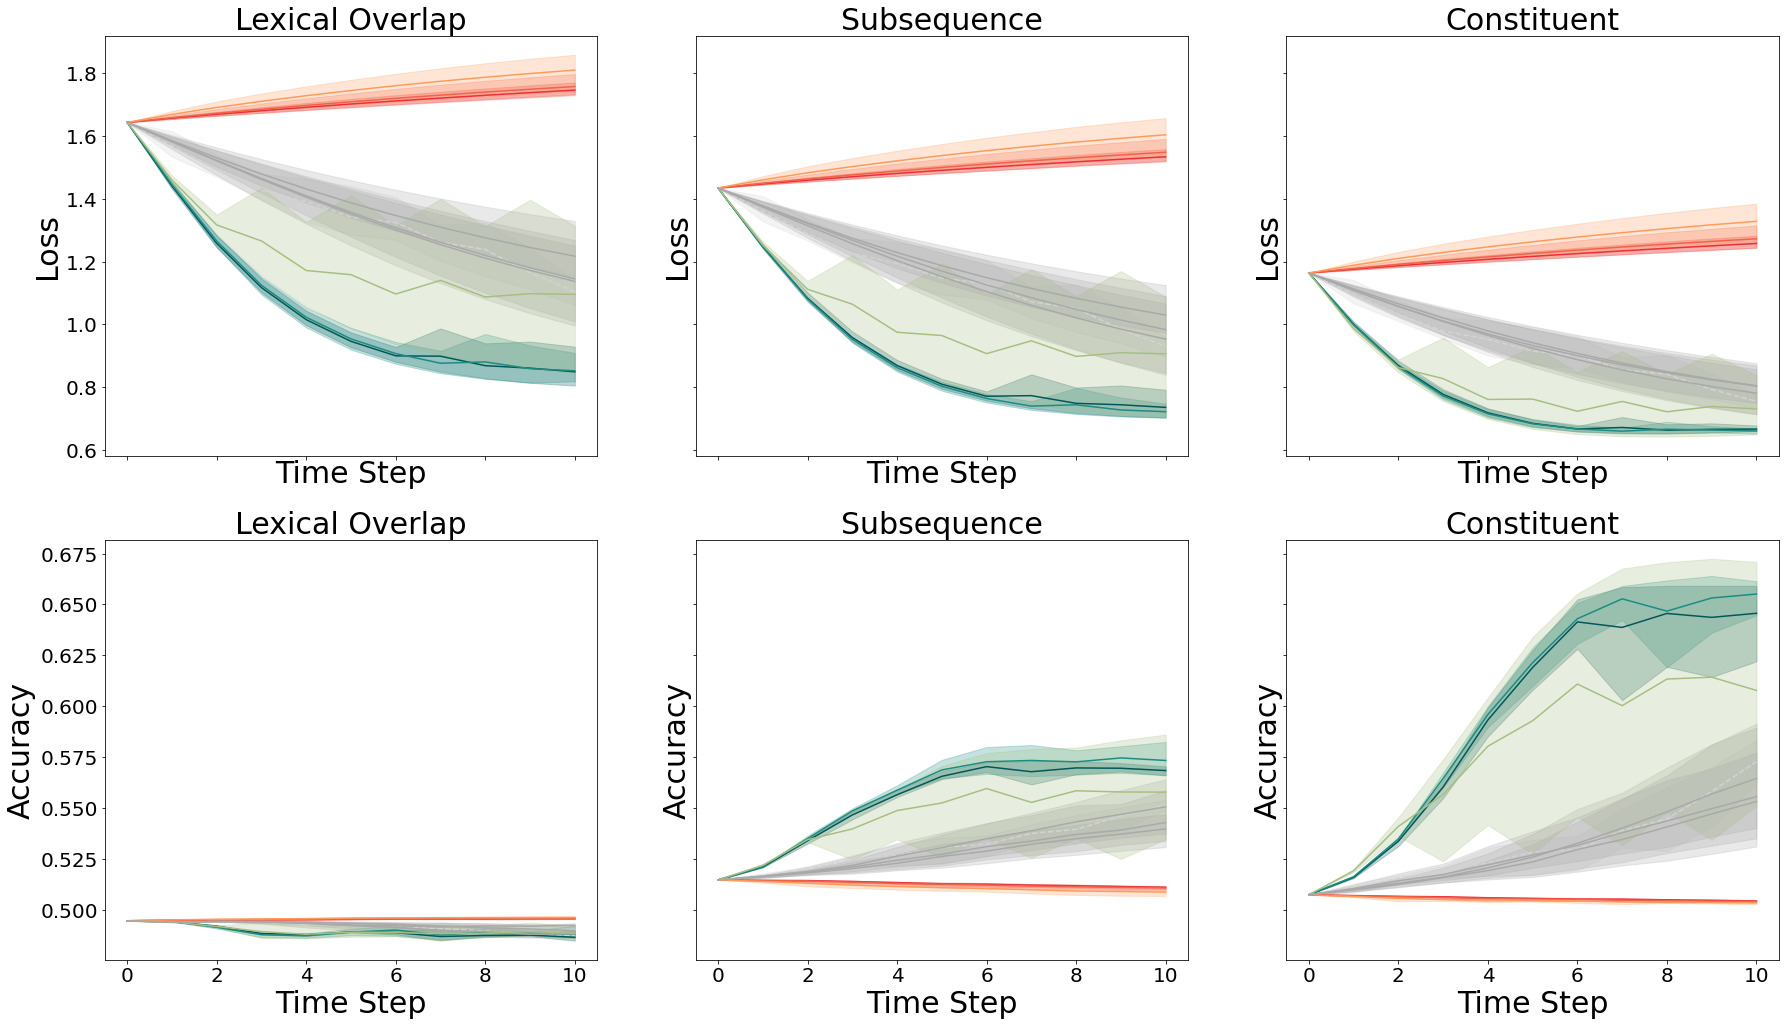

In [14]:
plt.rcParams["figure.figsize"] = (30, 17)
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20


fig, axes = plt.subplots(2, 3, sharex=True, sharey="row")
for metric_index, metric_name in enumerate(["loss", "accuracy"]):
    for slice_index, slice_name in enumerate(hans.DEFAULT_EVAL_HEURISTICS):
        
        # The random numbers are the same,
        # so just pick one of them
        Ys_dict = {
            f"random": np.array([
                [output_collections
                 ["lexical_overlap"]
                 ["new-only-z"]
                 [f"random-{replication_index}-{COMMON_KEY_SUFFIX}"]
                 [step_index]
                 [metric_name]
                 [slice_name]
                 for step_index in range(10)
                ] for replication_index in range(3)
            ])
        }
        for collection_key, collection in output_collections.items():
            if collection_key not in hans.DEFAULT_EVAL_HEURISTICS:
                raise ValueError

            Ys_dict[f"helpful-{collection_key}"] = np.array([
                [collection
                 ["new-only-z"]
                 [f"most-helpful-{replication_index}-{COMMON_KEY_SUFFIX}"]
                 [step_index]
                 [metric_name]
                 [slice_name]
                 for step_index in range(10)
                ] for replication_index in range(3)
            ])

            Ys_dict[f"harmful-{collection_key}"] = np.array([
                [collection
                 ["new-only-z"]
                 [f"most-harmful-{replication_index}-{COMMON_KEY_SUFFIX}"]
                 [step_index]
                 [metric_name]
                 [slice_name]
                 for step_index in range(10)
                ] for replication_index in range(3)
            ])

            Ys_dict[f"z-test-{collection_key}"] = np.array([
                [collection
                 ["new-only-ztest"]
                 [f"random-{replication_index}-{COMMON_KEY_SUFFIX}"]
                 [step_index]
                 [metric_name]
                 [slice_name]
                 for step_index in range(10)
                ] for replication_index in range(3)
            ])

        plot_Xs_and_Ys_dict(
            axis=axes[metric_index, slice_index],
            Xs=range(10 + 1),  # `+1` for the original performance
            Ys_dict=Ys_dict,
            baseline=_get_original_performance(metric_name, slice_name),
            title=" ".join([m.capitalize() for m in slice_name.split("_")]),
            xlabel="Time Step",
            ylabel=metric_name.capitalize(),
            xscale_log=False,
            yscale_log=False)

In [15]:
fig.savefig(f"./20201209-hans-augmentation-using-{TASK_NAME}.pdf")

In [16]:
torch.save(output_collections,
           f"./figures/20201209-hans-augmentation-using-{TASK_NAME}.output_collections.pt")

In [9]:
hans_helper._hans_eval_df.groupby("heuristic").count()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,pairID,subcase,template
heuristic,,,,,,,,,,
constituent,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
lexical_overlap,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
subsequence,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


# Get the Original Losses/Accuracies

In [1]:
cd /workspace/fast-influence-functions/

/workspace/fast-influence-functions


In [2]:
from tqdm import tqdm
from experiments.hans import *

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
def main(
        train_task_name: str,
        train_heuristic: str,
        eval_heuristics: Optional[List[str]] = None,
        num_replicas: Optional[int] = None,
        use_parallel: bool = True,
        version: Optional[str] = None,
) -> Dict[str, List[Dict[str, Any]]]:

    if train_task_name not in ["mnli-2", "hans"]:
        raise ValueError

    if eval_heuristics is None:
        eval_heuristics = DEFAULT_EVAL_HEURISTICS

    if num_replicas is None:
        num_replicas = DEFAULT_NUM_REPLICAS

    # if version not in ["new-only-z", "new-only-ztest", "new-z-and-ztest"]:
    #     raise ValueError

    task_tokenizer, task_model = misc_utils.create_tokenizer_and_model(
        constants.MNLI2_MODEL_PATH)

    (mnli_train_dataset,
     mnli_eval_dataset) = misc_utils.create_datasets(
        task_name="mnli-2",
        tokenizer=task_tokenizer)

    (hans_train_dataset,
     hans_eval_dataset) = misc_utils.create_datasets(
        task_name="hans",
        tokenizer=task_tokenizer)

    if train_task_name == "mnli-2":
        train_dataset = mnli_train_dataset

    if train_task_name == "hans":
        train_dataset = hans_train_dataset

    (s_test_damp,
     s_test_scale,
     s_test_num_samples) = influence_helpers.select_s_test_config(
        trained_on_task_name="mnli-2",
        train_task_name=train_task_name,
        eval_task_name="hans",
    )

    hans_helper = HansHelper(
        hans_train_dataset=hans_train_dataset,
        hans_eval_dataset=hans_eval_dataset)
    
    return hans_helper

In [4]:
hans_helper = main(
    # These arguments don't matter
    train_task_name="hans",
    train_heuristic=None)

Params Trainable: 14767874
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

In [5]:
_, mnli_model = misc_utils.create_tokenizer_and_model(
    constants.MNLI2_MODEL_PATH)
_, hans_model = misc_utils.create_tokenizer_and_model(
    constants.HANS_MODEL_PATH)

# Most of these arguments are placeholders
# and are not really used at all, so ignore
# the exact values of these.
mnli_trainer = transformers.Trainer(
    model=mnli_model,
    args=TrainingArguments(
        output_dir="./tmp-output",
        per_device_train_batch_size=128,
        per_device_eval_batch_size=128,
        learning_rate=5e-5,
        logging_steps=100),
)

hans_trainer = transformers.Trainer(
    model=hans_model,
    args=TrainingArguments(
        output_dir="./tmp-output",
        per_device_train_batch_size=128,
        per_device_eval_batch_size=128,
        learning_rate=5e-5,
        logging_steps=100),
)

Params Trainable: 14767874
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


In [6]:
mnli_losses = {}
hans_losses = {}
mnli_accuracies = {}
hans_accuracies = {}

for _model, _trainer, _losses, _accuracies in zip(
        [mnli_model, hans_model],
        [mnli_trainer, hans_trainer],
        [mnli_losses, hans_losses],
        [mnli_accuracies, hans_accuracies]):

    for heuristic in tqdm(DEFAULT_EVAL_HEURISTICS):
        new_model_loss, new_model_accuracy = evaluate_heuristic(
            hans_helper=hans_helper,
            heuristic=heuristic,
            trainer=_trainer,
            model=_model)

        _losses[heuristic] = new_model_loss
        _accuracies[heuristic] = new_model_accuracy

100%|██████████| 3/3 [01:03<00:00, 21.16s/it]


In [8]:
# torch.save({
#    "losses": {
#        "mnli-2": mnli_losses,
#        "hans": hans_losses,
#    },
#    "accuracies": {
#        "mnli-2": mnli_accuracies,
#        "hans": hans_accuracies,
#    },
# }, "/export/home/hguo/Experiments/20201209/original-performances.pt")

In [9]:
torch.load("/export/home/hguo/Experiments/20201209/original-performances.pt")

{'losses': {'mnli-2': {'lexical_overlap': 1.6429600160568953,
   'subsequence': 1.43410438336432,
   'constituent': 1.1635971263051033},
  'hans': {'lexical_overlap': 0.11694738194346428,
   'subsequence': 0.011955874529667199,
   'constituent': 0.00398832923383452}},
 'accuracies': {'mnli-2': {'lexical_overlap': 0.4945,
   'subsequence': 0.5146,
   'constituent': 0.5073},
  'hans': {'lexical_overlap': 0.9599,
   'subsequence': 0.9978,
   'constituent': 0.9996}}}